In [1]:
from transformer.Models import Transformer

In [2]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import time
import yaml
from argparse import ArgumentParser


# from transformer.Models import Transformer, Encoder, Decoder
# from datasets.quora_bert_mask_predict_prob_dataset import QuoraBertMaskPredictProbDataset
from transformer.Optim import ScheduledOptim

In [3]:
from tqdm import tqdm
import re
import numpy as np
from transformers import BertTokenizer, BertForMaskedLM
import os
import random

class QuoraBertMaskPredictProbDataset(Dataset):
    def __init__(self, mode, train_size=5000, val_size=1000, test_size=1000, 
                 text_path='../data/quora_train.txt', pretrained_model_name='bert-base-cased', preprocessed_folder=None):
        assert mode in ["train", "val", "test"]
        self.mode = mode
        self.train_size = train_size
        self.val_size = val_size
        self.test_size = test_size
        
        self.tokenizer = self.init_tokenizer(pretrained_model_name)
        self.mask_predict_model = BertForMaskedLM.from_pretrained(pretrained_model_name)
        self.sentences = self.read_text(text_path)
        self.init_constants()
        self.softmax = torch.nn.Softmax(dim=1)
        
        self.n_words = len(self.tokenizer)
        
        if preprocessed_folder is not None and os.path.exists(preprocessed_folder):
            self.preprocessed_folder = preprocessed_folder
        else:
            self.preprocessed_folder = None
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            self.mask_predict_model = self.mask_predict_model.to(self.device)

    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        seq1, seq2 = sentence.split('\t')
        
        tokens1 = self.tokenizer.tokenize(seq1)
        word_pieces1 =  [self.SOS_token] + tokens1 + [self.EOS_token]
        idxes1 = self.tokenizer.convert_tokens_to_ids(word_pieces1)
        
        tokens2 = self.tokenizer.tokenize(seq2)
        word_pieces2 = [self.SOS_token] + tokens2 + [self.EOS_token]
        idxes2 = self.tokenizer.convert_tokens_to_ids(word_pieces2)
        
        seq1_tensor = torch.tensor(idxes1, dtype=torch.long)
        seq2_tensor = torch.tensor(idxes2, dtype=torch.long)
        
        if self.preprocessed_folder is not None:
            if self.mode == 'train':
                pretrained_idx = idx
            elif self.mode == 'val':
                pretrained_idx = self.train_size + idx
            else:
                pretrained_idx = self.train_size + self.val_size + idx
            preprocessed_file = "{}/{}.npy".format(self.preprocessed_folder, pretrained_idx)
            mask_probs = np.load(preprocessed_file, allow_pickle=True)
            mask_probs = torch.tensor(mask_probs)
        else:
            # mask each word from the begining to the end
            # get the probability distribution of the mask tokens
            pred = self.get_mask_pred_probs(seq1_tensor)
            mask_probs = self.get_stack_probs(pred)
        
        return seq1_tensor, seq2_tensor, mask_probs

    def __len__(self):
        if self.mode == 'train':
            return self.train_size
        elif self.mode == 'val':
            return self.val_size
        else:
            return self.test_size
        
    # [CLS]  [M]  w2  w3  [SEP]        
    # [CLS]  w1  [M]  w3  [SEP]        
    # [CLS]  w1 w2  [M]  [SEP]        
    # get the probability of [M] for each mask-prediction case
    # mask for (number of words) times and every time get (number of words + 2) probability
    # TODO: get the pred for only once
    def get_mask_pred_probs(self, seq1):
        mask_sentences = []
        
        for i in range(1, len(seq1) - 1):
            mask_seq = seq1.detach().clone()
            mask_seq[i] = self.MASK_token_id
            mask_sentences.append(mask_seq)

        mask_stack = torch.stack(mask_sentences)
        mask_stack = mask_stack.to(self.device)
        
        self.mask_predict_model.eval()

        with torch.no_grad():
            pred = self.mask_predict_model(mask_stack)[0]
        pred = pred.cpu()
        return pred
    
    def get_stack_probs(self, pred):
        bos_prob = torch.zeros(self.n_words)
        bos_prob[self.SOS_token_id] = 1

        eos_prob = torch.zeros(self.n_words)
        eos_prob[self.EOS_token_id] = 1

        mask_preds = []
        for idx in range(pred.shape[0]):
            mask_preds.append(pred[idx][idx+1])
        mask_stack = torch.stack(mask_preds)
        mask_stack = torch.cat((bos_prob.reshape(1,-1), mask_stack, eos_prob.reshape(1,-1)))
        return mask_stack
    
    def init_tokenizer(self, pretrained_model_name):
        tokenizer = BertTokenizer.from_pretrained(pretrained_model_name)
        return tokenizer
    
    def init_constants(self):
        PAD_id,  SOS_id, EOS_id, UNK_id = self.tokenizer.convert_tokens_to_ids(["[PAD]", "[CLS]", "[SEP]", "[UNK]"])
        self.PAD_token_id = PAD_id
        self.SOS_token_id = SOS_id
        self.EOS_token_id = EOS_id
        self.UNK_token_id = UNK_id
        
        self.PAD_token = '[PAD]'
        self.SOS_token = '[CLS]'
        self.EOS_token = '[SEP]'
        self.UNK_token = '[UNK]'
        
        self.MASK_token = '[MASK]'
        self.MASK_token_id = self.tokenizer.convert_tokens_to_ids(["[MASK]"])[0]

        
    def read_text(self, text_path):
        # add words to dictionary
        f = open(text_path, 'r')
        lines = f.readlines()
        # shuffle
        np.random.shuffle(lines)
        if self.mode == "train":
            lines = lines[:self.train_size]
        elif self.mode == 'val':
            lines = lines[self.train_size:self.train_size+self.val_size]
        else:
            lines = lines[self.train_size+self.val_size:self.train_size+self.val_size+self.test_size]
        
        return lines

    

In [4]:
seed = 0
# seed = 777
# seed = 33333

# fix seed
def same_seeds(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  
    np.random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

same_seeds(seed)

In [5]:
##### Read Arguments from Config File #####

config_path = '../../configs/dpng_transformer_bert_attention.yaml'

with open(config_path) as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
print(config)

# save_model_path = config['save_model_path']
# log_file = config['log_file']
# preprocessed_folder = config['preprocessed_folder']
save_model_path = '../../models/tune/transformer_key_enc_bert_val_attention_alpha0.5.pth'
log_file = '../../logs/tune/transformer_key_enc_bert_val_attention_alpha0.5.txt'
output_file = '../../outputs/tune/transformer_key_enc_bert_val_attention_alpha0.5.txt'

# set model and log path
seed_model_root = '../../models/fixseed/seed{}/'.format(seed)
seed_log_root = '../../logs/fixseed/seed{}/'.format(seed)
seed_output_root = '../../outputs/fixseed/seed{}/'.format(seed)

if not os.path.exists(seed_model_root):
    os.makedirs(seed_model_root)

if not os.path.exists(seed_log_root):
    os.makedirs(seed_log_root)

save_model_path = seed_model_root + save_model_path.split('/')[-1]
log_file = seed_log_root + log_file.split('/')[-1]
output_file = seed_output_root + output_file.split('/')[-1]
print('seed: ', seed)
print('save model path: ', save_model_path)
print('log path: ', log_file)
print('output path: ', output_file)

num_epochs = config['num_epochs']
batch_size = config['batch_size']

d_model = config['d_model']
d_inner_hid = config['d_inner_hid']
d_k = config['d_k']
d_v = config['d_v']

n_head = config['n_head']
n_layers = config['n_layers']
n_warmup_steps = config['n_warmup_steps']

dropout = config['dropout']
embs_share_weight = config['embs_share_weight']
proj_share_weight = config['proj_share_weight']
label_smoothing = config['label_smoothing']

train_size = config['train_size']
val_size = config['val_size']
test_size = config['test_size']


# ###################

{'save_model_path': '../models/transformer_bert_enc_attention.pth', 'log_file': '../logs/transformer_bert_enc_attention.txt', 'test_output_file': '../outputs/test_transformer_bert_enc_attention.txt', 'val_output_file': '../outputs/val_transformer_bert_enc_attention.txt', 'preprocessed_folder': '../data/preprocess_quora_bert_mask_predict/', 'dataset': 'quora_bert_dataset', 'num_epochs': 50, 'batch_size': 100, 'd_model': 450, 'd_inner_hid': 512, 'd_k': 50, 'd_v': 50, 'n_head': 9, 'n_layers': 3, 'n_warmup_steps': 12000, 'dropout': 0.1, 'embs_share_weight': True, 'proj_share_weight': True, 'label_smoothing': False, 'train_size': 100000, 'val_size': 4000, 'test_size': 20000, 'is_bow': False, 'lr': '1e-3'}
seed:  0
save model path:  ../../models/fixseed/seed0/transformer_key_enc_bert_val_attention_alpha0.5.pth
log path:  ../../logs/fixseed/seed0/transformer_key_enc_bert_val_attention_alpha0.5.txt
output path:  ../../outputs/fixseed/seed0/transformer_key_enc_bert_val_attention_alpha0.5.txt


In [6]:
# bert_alpha = 0 # normal
bert_alpha = 0.5 # half-half
# bert_alpha = 1 # only bert attention

In [ ]:
def create_mini_batch(samples):
    seq1_tensors = [s[0] for s in samples]
    seq2_tensors = [s[1] for s in samples]
    probs_tensors = [s[2] for s in samples]

    # zero pad
    seq1_tensors = pad_sequence(seq1_tensors,
                                  batch_first=True)

    seq2_tensors = pad_sequence(seq2_tensors,
                                  batch_first=True)
    probs_tensors = pad_sequence(probs_tensors,
                                  batch_first=True)
    
    return seq1_tensors, seq2_tensors, probs_tensors

dataset = QuoraBertMaskPredictProbDataset("train", train_size, val_size, text_path='../../data/quora_train.txt')
val_dataset = QuoraBertMaskPredictProbDataset("val", train_size, val_size, text_path='../../data/quora_train.txt')

data_loader = DataLoader(dataset, batch_size=batch_size, collate_fn=create_mini_batch, shuffle=True)
val_data_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=create_mini_batch, shuffle=False)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F

from transformer.SubLayers import MultiHeadAttention, PositionwiseFeedForward
from transformer.Models import get_pad_mask, get_subsequent_mask
from transformer.Models import PositionalEncoding, Encoder

# QKV: dec_out  enc_out  bert_out
class DecoderLayer(nn.Module):
    ''' Compose with three layers '''

    def __init__(self, d_model, d_inner, n_head, d_k, d_v, dropout=0.1, bert_alpha=0):
        super(DecoderLayer, self).__init__()
        self.slf_attn = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.enc_attn = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.bert_attn = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.pos_ffn = PositionwiseFeedForward(d_model, d_inner, dropout=dropout)
        self.bert_alpha = bert_alpha

    def forward(
            self, dec_input, enc_output, bert_out,
            slf_attn_mask=None, dec_enc_attn_mask=None):
        
        dec_output, dec_slf_attn = self.slf_attn(
            dec_input, dec_input, dec_input, mask=slf_attn_mask)
        
        dec_output, dec_enc_attn = self.enc_attn(
            dec_output, enc_output, enc_output, mask=dec_enc_attn_mask)
        
        dec_bert_output, dec_enc_bert_attn = self.bert_attn(
            dec_output, enc_output, bert_out, mask=dec_enc_attn_mask)
        
        dec_output = (1-self.bert_alpha) *  dec_output + self.bert_alpha * dec_bert_output
        
        dec_output = self.pos_ffn(dec_output)
        return dec_output, dec_slf_attn, dec_enc_attn





In [ ]:

class Decoder(nn.Module):
    ''' A decoder model with self attention mechanism. '''

    def __init__(
            self, n_trg_vocab, d_word_vec, n_layers, n_head, d_k, d_v,
            d_model, d_inner, pad_idx, n_position=200, dropout=0.1, bert_alpha=0):

        super().__init__()

        self.trg_word_emb = nn.Embedding(n_trg_vocab, d_word_vec, padding_idx=pad_idx)
        self.position_enc = PositionalEncoding(d_word_vec, n_position=n_position)
        self.dropout = nn.Dropout(p=dropout)
        self.layer_stack = nn.ModuleList([
            DecoderLayer(d_model, d_inner, n_head, d_k, d_v, dropout=dropout, bert_alpha=bert_alpha)
            for _ in range(n_layers)])
        self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)

    def forward(self, trg_seq, trg_mask, enc_output, bert_out, src_mask, return_attns=False):

        dec_slf_attn_list, dec_enc_attn_list = [], []

        # -- Forward
        dec_output = self.dropout(self.position_enc(self.trg_word_emb(trg_seq)))
        dec_output = self.layer_norm(dec_output)
        
#         print('encoder output', enc_output.shape)
#         print('decoder output', dec_output.shape)
#         print('bert output', bert_out.shape)

        for dec_layer in self.layer_stack:
            dec_output, dec_slf_attn, dec_enc_attn = dec_layer(
                dec_output, enc_output, bert_out, slf_attn_mask=trg_mask, dec_enc_attn_mask=src_mask)
            dec_slf_attn_list += [dec_slf_attn] if return_attns else []
            dec_enc_attn_list += [dec_enc_attn] if return_attns else []

        if return_attns:
            return dec_output, dec_slf_attn_list, dec_enc_attn_list
        return dec_output,

In [ ]:
class Transformer(nn.Module):
    ''' A sequence to sequence model with attention mechanism. '''

    def __init__(
            self, n_src_vocab, n_trg_vocab, src_pad_idx, trg_pad_idx,
            d_word_vec=512, d_model=512, d_inner=2048,
            n_layers=6, n_head=8, d_k=64, d_v=64, dropout=0.1, n_position=200,
            trg_emb_prj_weight_sharing=True, emb_src_trg_weight_sharing=True, bert_alpha=0):

        super().__init__()

        self.src_pad_idx, self.trg_pad_idx = src_pad_idx, trg_pad_idx
        
        self.probnn = nn.Linear(n_src_vocab, d_model)

        self.encoder = Encoder(
            n_src_vocab=n_src_vocab, n_position=n_position,
            d_word_vec=d_word_vec, d_model=d_model, d_inner=d_inner,
            n_layers=n_layers, n_head=n_head, d_k=d_k, d_v=d_v,
            pad_idx=src_pad_idx, dropout=dropout)

        self.decoder = Decoder(
            n_trg_vocab=n_trg_vocab, n_position=n_position,
            d_word_vec=d_word_vec, d_model=d_model, d_inner=d_inner,
            n_layers=n_layers, n_head=n_head, d_k=d_k, d_v=d_v,
            pad_idx=trg_pad_idx, dropout=dropout, bert_alpha=bert_alpha)

        self.trg_word_prj = nn.Linear(d_model, n_trg_vocab, bias=False)

        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p) 

        assert d_model == d_word_vec, \
        'To facilitate the residual connections, \
         the dimensions of all module outputs shall be the same.'

        self.x_logit_scale = 1.
        if trg_emb_prj_weight_sharing:
            # Share the weight between target word embedding & last dense layer
            self.trg_word_prj.weight = self.decoder.trg_word_emb.weight
            self.x_logit_scale = (d_model ** -0.5)

        if emb_src_trg_weight_sharing:
            self.encoder.src_word_emb.weight = self.decoder.trg_word_emb.weight


    def forward(self, src_seq, trg_seq, bert_prob, return_attns=False):
        src_mask = get_pad_mask(src_seq, self.src_pad_idx)
        trg_mask = get_pad_mask(trg_seq, self.trg_pad_idx) & get_subsequent_mask(trg_seq)

        enc_output, enc_slf_attn_list = self.encoder(src_seq, src_mask, return_attns=True)
        
        bert_out = self.probnn(bert_prob)
#         print("bert prod:", bert_prob.shape)
#         print("(trans) bert out: ", bert_out.shape)
        
        dec_output, dec_slf_attn_list, dec_enc_attn_list = self.decoder(trg_seq, trg_mask, enc_output, bert_out, src_mask, return_attns=True)
        seq_logit = self.trg_word_prj(dec_output) * self.x_logit_scale

        if return_attns:
            return seq_logit.view(-1, seq_logit.size(2)), enc_slf_attn_list, dec_slf_attn_list, dec_enc_attn_list
        return seq_logit.view(-1, seq_logit.size(2))


In [ ]:
transformer = Transformer(
    dataset.n_words,
    dataset.n_words,
    src_pad_idx=dataset.PAD_token_id,
    trg_pad_idx=dataset.PAD_token_id,
    trg_emb_prj_weight_sharing=proj_share_weight,
    emb_src_trg_weight_sharing=embs_share_weight,
    d_k=d_k,
    d_v=d_v,
    d_model=d_model,
    d_word_vec=d_model,
    d_inner=d_inner_hid,
    n_layers=n_layers,
    n_head=n_head,
    dropout=dropout,
    bert_alpha=bert_alpha
)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = transformer.to(device)

In [ ]:
from transformer.CustomModels import Translator


In [ ]:
import re
import numpy as np

class QuoraTextDataset(Dataset):
    def __init__(self, mode, train_size=5000, val_size=1000, test_size=1000, text_path='../data/quora_train.txt'):
        assert mode in ["train", "val", "test"]
        self.mode = mode
        self.train_size = train_size
        self.val_size = val_size
        self.test_size = test_size
        self.sentences = []

        self._init_sentences(text_path)

    def __getitem__(self, idx):
        return self.sentences[idx]
        seq1, seq2 = self.sentences[idx]

    def __len__(self):
        if self.mode == 'train':
            return self.train_size
        elif self.mode == 'val':
            return self.val_size
        else:
            return self.test_size
    
    def _init_sentences(self, text_path):
        f = open(text_path, 'r')
        lines = f.readlines()
        np.random.shuffle(lines)
        if self.mode == "train":
            lines = lines[:self.train_size]
        elif self.mode == 'val':
            lines = lines[self.train_size:self.train_size+self.val_size]
        else:
            lines = lines[self.train_size+self.val_size:self.train_size+self.val_size+self.test_size]
        
        def normalize_sentence(s):
            s = re.sub(r"([.!?])", r" \1", s)
            s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
            return s

        for line in lines:
            seq1, seq2 = [normalize_sentence(seq) for seq in line.split('\t')]
            self.sentences.append((seq1, seq2))

        

In [ ]:
tbatch_size = 1
beam_size = 3
max_seq_len = 30

same_seeds(seed)

# dataset = QuoraBertMaskPredictProbDataset("test", train_size, val_size, test_size, preprocessed_folder=preprocessed_folder)
test_dataset = QuoraBertMaskPredictProbDataset("test", train_size, val_size, test_size, text_path='../../data/quora_train.txt')

same_seeds(seed) 
text_dataset = QuoraTextDataset("test", train_size, val_size, test_size, text_path='../../data/quora_train.txt')
test_data_loader = DataLoader(test_dataset, batch_size=tbatch_size, collate_fn=create_mini_batch, shuffle=False)

In [ ]:
model.load_state_dict((torch.load(
        save_model_path, map_location=device)))

In [ ]:
src_pad_idx = dataset.PAD_token_id
trg_pad_idx = dataset.PAD_token_id
    
trg_bos_idx = dataset.SOS_token_id
trg_eos_idx = dataset.EOS_token_id
unk_idx = dataset.UNK_token_id

In [18]:
translator = Translator(
        model=model,
        beam_size=beam_size,
        max_seq_len=max_seq_len,
        src_pad_idx=src_pad_idx,
        trg_pad_idx=trg_pad_idx,
        trg_bos_idx=trg_bos_idx,
        trg_eos_idx=trg_eos_idx,
).to(device)

In [19]:
# dry-run
it = iter(test_data_loader)
i = 1
for _ in range(i):
    next(it)

seq1, seq2, bert_prob = next(it)
input_seq = seq1.to(device)
bert_prob = bert_prob.to(device)
pred_seq = translator.translate_sentence(input_seq, bert_prob)
print(dataset.tokenizer.convert_ids_to_tokens(pred_seq))

['[CLS]', 'How', 'can', 'I', 'learn', 'faster', '?', '[SEP]']


In [20]:
print(test_dataset.sentences[i])
_, _, mp = test_dataset[i]
soft = torch.nn.Softmax(dim=1)
mp = soft(mp)
print(mp.shape)
prob, indices = torch.topk(mp[4], 40)
print(prob)
dataset.tokenizer.convert_ids_to_tokens(list(indices.numpy()))

How can I speak faster?	How can you speak faster?

torch.Size([8, 28996])
tensor([0.2046, 0.1890, 0.1698, 0.1139, 0.1039, 0.0461, 0.0262, 0.0234, 0.0220,
        0.0063, 0.0040, 0.0038, 0.0037, 0.0031, 0.0030, 0.0024, 0.0024, 0.0023,
        0.0015, 0.0015, 0.0014, 0.0014, 0.0014, 0.0013, 0.0013, 0.0013, 0.0013,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0009, 0.0009, 0.0009, 0.0009])


['go',
 'move',
 'run',
 'walk',
 'be',
 'get',
 'travel',
 'think',
 'drive',
 'breathe',
 'swim',
 'see',
 'fly',
 'heal',
 'talk',
 'turn',
 'work',
 'come',
 'sprint',
 'ride',
 'live',
 'race',
 'do',
 'fight',
 'escape',
 'fall',
 'beat',
 'know',
 'jump',
 'dance',
 'speed',
 'learn',
 'step',
 'die',
 'function',
 'speak',
 'change',
 'pass',
 'shift',
 'read']

In [33]:
print(sum(bert_prob[0][1]))
print(sum(bert_prob[0][4]))

tensor(-86045.5859, device='cuda:0')
tensor(-84083.0859, device='cuda:0')


In [29]:
# diter = iter(test_data_loader)
# _ = next(diter)
# _ = next(diter)
# seq1_tensor, seq2_tensor, mask_prob = next(diter)
# print(seq1_tensor.shape)
# print(dataset.tokenizer.convert_ids_to_tokens(seq1_tensor[0]))


torch.Size([1, 14])
['[CLS]', 'What', 'is', 'the', 'best', 'laptop', 'under', 'IN', '##R', '30', ',', '000', '?', '[SEP]']


In [ ]:
dataset.tokenizer.convert_tokens_to_ids(['novels', 'books', 'book', 'comic', 'story'])

In [32]:
# build mask stack
bos_prob = torch.zeros(dataset.n_words)
bos_prob[dataset.SOS_token_id] = 1

eos_prob = torch.zeros(dataset.n_words)
eos_prob[dataset.EOS_token_id] = 1

mask_preds = []
for i, idx in enumerate(seq1_tensor[0,:]):
    prob = torch.zeros(dataset.n_words)
    prob[idx] = 1
    
    if idx == 5520:
        prob[idx] = 0
        prob[2146] = 0
        prob[1520] = 0
        prob[4824] = 0
        prob[1642] = 0
    mask_preds.append(prob)
#     print(idx, prob[idx], len(mask_preds))
mask_stack = torch.stack(mask_preds)
print(mask_stack.shape)



NameError: name 'seq1_tensor' is not defined

In [ ]:
mask_stack = mask_stack.reshape(1, len(seq1_tensor[0]), -1)
print(mask_stack.shape)

In [ ]:
# dry-run
diter = iter(test_data_loader)
# _ = next(diter)
_ = next(diter)
seq1, seq2, bert_prob = next(diter)
input_seq = seq1.to(device)
bert_prob = bert_prob.to(device)
pred_seq = translator.translate_sentence(input_seq, bert_prob)
print(dataset.tokenizer.convert_ids_to_tokens(pred_seq))

In [ ]:
# analyze model probnn

In [23]:
weight = model.probnn.weight
weight[0].shape

torch.Size([28996])

In [55]:
word = 'value'
word2 = 'prefer'
for i in range(450):
    w = weight[i].cpu().detach()
    prob, indices = torch.topk(w, 30)
    tokens = dataset.tokenizer.convert_ids_to_tokens(list(indices.numpy()))
#     print("-----------------------------")
#     print(tokens)
    if word in tokens:
        print("-----------------------------")
        if word2 in tokens:
            print("[Info] Find word2 here!")
        print(tokens)
        

-----------------------------
['ex', 'online', 'title', 'con', 'ID', 'ad', 'wanted', 'purpose', 'charge', 'kind', 'com', 'am', 'tax', 'f', '##able', 'needed', 'proof', 'insurance', 'myself', 'file', 'value', 'running', 'mi', 'que', 'address', 'pack', 'worth', 'want', 'murder', 'needs']
-----------------------------
['tone', '_', '#', 'market', 'box', 'London', 'value', 'word', 'itself', 'action', 'room', 'rather', 'house', 'industry', 'mostly', 'definitely', 'needs', 'voice', 'title', 'feature', 'bar', 'especially', 'obviously', 'written', 'field', '$', 'based', 'somewhere', '@', 'popular']
-----------------------------
['lost', 'truly', 'worth', 'living', 'm', 'quite', 'ones', 'such', 'unknown', 'fixed', 'nearly', 'outside', 'self', 'field', 'talent', 'million', 'myself', 'perfect', 'revolution', 'Masters', 'M', 'enemy', 'value', 'built', 'city', 'n', 'away', 'bottom', 'dead', 'building']
-----------------------------
['price', 'simple', 'common', 'cost', 'market', 'oil', 'health', 'l

In [35]:
# analyze the context embedding
# s1 = "How do I know my inner talent ?"
# s2 = "How can I find my inner talent ?"
# fig_path = "../../analysis/figs/cos_1.png"

# s1 = "Why does society value skinny people more than overweight people ?"
# s2 = "Why do people prefer skinny than others ?"
# fig_path = "../../analysis/figs/cos_2.png"

# s1 = "How can I speak faster ?"
# s2 = "How can I learn faster ?"
# fig_path = "../../analysis/figs/cos_3.png"

# s1 = "Why does society value skinny people more than overweight people ?"
# s2 = "Why does society prefer skinny people more than overweight people ?"
# fig_path = "../../analysis/figs/cos_2.png"

s1 = "How can you learn fast ?"
s2 = "How can I learn faster ?"

tokens1 = dataset.tokenizer.tokenize(s1)
word_pieces1 =  [dataset.SOS_token] + tokens1 + [dataset.EOS_token]
idxes1 = dataset.tokenizer.convert_tokens_to_ids(word_pieces1)

tokens2 = dataset.tokenizer.tokenize(s2)
word_pieces2 =  [dataset.SOS_token] + tokens2 + [dataset.EOS_token]
idxes2 = dataset.tokenizer.convert_tokens_to_ids(word_pieces2)

print(word_pieces1, word_pieces2)

seq1 = torch.tensor(idxes1, dtype=torch.long)
seq2 = torch.tensor(idxes2, dtype=torch.long)

pred1 = dataset.get_mask_pred_probs(seq1)
pred2 = dataset.get_mask_pred_probs(seq2)

probs1 = dataset.get_stack_probs(pred1)
probs2 = dataset.get_stack_probs(pred2)
print(probs1.shape, probs2.shape)

['[CLS]', 'How', 'can', 'you', 'learn', 'fast', '?', '[SEP]'] ['[CLS]', 'How', 'can', 'I', 'learn', 'faster', '?', '[SEP]']
torch.Size([8, 28996]) torch.Size([8, 28996])


In [36]:
out1 = model.probnn(probs1.to(device))
out2 = model.probnn(probs2.to(device))
print(out1.shape, out2.shape)

torch.Size([8, 450]) torch.Size([8, 450])


In [37]:
from sklearn.metrics.pairwise import cosine_similarity
out1 = out1.cpu().detach().numpy()
out2 = out2.cpu().detach().numpy()
ret = cosine_similarity(out1, out2)
print(len(ret), len(ret[0]))

8 8


In [38]:
print(ret[3][3])

0.98913157


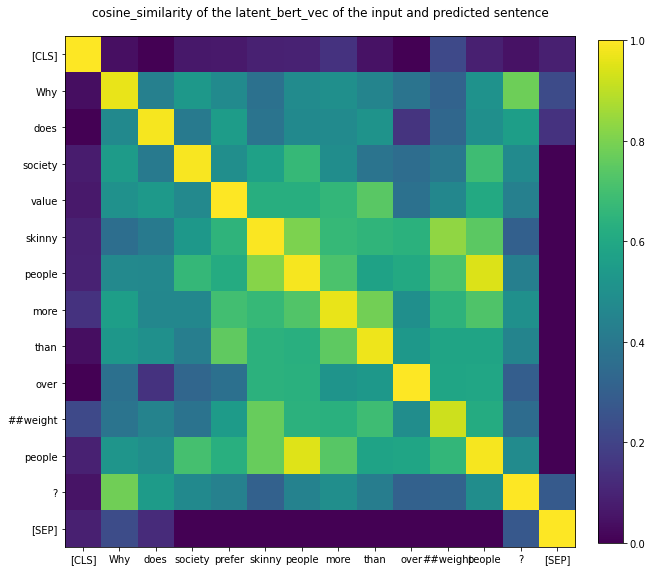

In [24]:
from matplotlib import pyplot as plt

# plt.figure(figsize = (6, 6))
plt.figure(figsize = (10, 10))


x = np.arange(0, len(word_pieces2), 1)
y = np.arange(0, len(word_pieces1), 1)
plt.xticks(x, word_pieces2)
plt.yticks(y, word_pieces1)

# im = plt.imshow(ret,  interpolation='nearest', aspect='auto')
im = plt.imshow(ret,  interpolation='nearest')
plt.title("cosine_similarity of the latent_bert_vec of the input and predicted sentence", pad=20)

plt.clim(1.0,0.0)
plt.colorbar(im, fraction=0.045, pad=0.04)

# plt.savefig(fig_path, dpi=100, bbox_inches='tight')

In [70]:
_, indices = torch.topk(probs1[4], 20)
print(indices)
dataset.tokenizer.convert_ids_to_tokens(list(indices.numpy()))

tensor([ 1329,  1654,  4750,  1525,  3094,  4137,  3283,  5494, 17573, 20211,
         4282, 21689,  3244, 23487,  1221,  7290,  1243,  3857,  3689,  9703])


['use',
 'control',
 'hide',
 'find',
 'channel',
 'explain',
 'master',
 'manage',
 'utilize',
 'harness',
 'handle',
 'conceal',
 'protect',
 'manifest',
 'know',
 'discover',
 'get',
 'lose',
 'develop',
 'acquire']

In [184]:
# analyze the context embedding
# s1 = "How do I know my inner talent ?"
# s2 = "How can I find my inner talent ?"
# fig_path = "../../analysis/figs/cos_enc_1.png"

s1 = "Why does society value skinny people more than overweight people ?"
s2 = "Why do people prefer skinny than others ?"
fig_path = "../../analysis/figs/cos_enc_2.png"

# s1 = "How can I speak faster ?"
# s2 = "How can I learn faster ?"
# fig_path = "../../analysis/figs/cos_enc_3.png"

tokens1 = dataset.tokenizer.tokenize(s1)
word_pieces1 =  [dataset.SOS_token] + tokens1 + [dataset.EOS_token]
idxes1 = dataset.tokenizer.convert_tokens_to_ids(word_pieces1)

tokens2 = dataset.tokenizer.tokenize(s2)
word_pieces2 =  [dataset.SOS_token] + tokens2 + [dataset.EOS_token]
idxes2 = dataset.tokenizer.convert_tokens_to_ids(word_pieces2)

print(word_pieces1, word_pieces2)

seq1 = torch.tensor(idxes1, dtype=torch.long)
seq2 = torch.tensor(idxes2, dtype=torch.long)

pred1 = dataset.get_mask_pred_probs(seq1)
pred2 = dataset.get_mask_pred_probs(seq2)

probs1 = dataset.get_stack_probs(pred1)
probs2 = dataset.get_stack_probs(pred2)
print(probs1.shape, probs2.shape)

['[CLS]', 'Why', 'does', 'society', 'value', 'skinny', 'people', 'more', 'than', 'over', '##weight', 'people', '?', '[SEP]'] ['[CLS]', 'Why', 'do', 'people', 'prefer', 'skinny', 'than', 'others', '?', '[SEP]']
torch.Size([14, 28996]) torch.Size([10, 28996])


In [185]:
# output of encoder
src_seq = seq1.reshape(1, -1).to(device)
src_mask = get_pad_mask(src_seq, model.src_pad_idx)
enc_output, enc_slf_attn_list = model.encoder(src_seq, src_mask, return_attns=True)
enc_out1 = enc_output.reshape(len(seq1), -1)

src_seq = seq2.reshape(1, -1).to(device)
src_mask = get_pad_mask(src_seq, model.src_pad_idx)
enc_output, enc_slf_attn_list = model.encoder(src_seq, src_mask, return_attns=True)
enc_out2 = enc_output.reshape(len(seq2), -1)

In [186]:
out1 = enc_out1.cpu().detach().numpy()
out2 = enc_out2.cpu().detach().numpy()
ret = cosine_similarity(out1, out2)
print(len(ret), len(ret[0]))

14 10


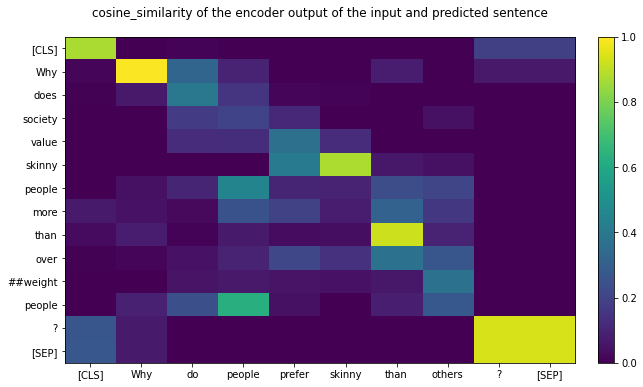

In [187]:
plt.figure(figsize = (10, 6))

x = np.arange(0, len(word_pieces2), 1)
y = np.arange(0, len(word_pieces1), 1)
plt.xticks(x, word_pieces2)
plt.yticks(y, word_pieces1)

im = plt.imshow(ret,  interpolation='nearest', aspect='auto')
# im = plt.imshow(ret,  interpolation='nearest')
plt.title("cosine_similarity of the encoder output of the input and predicted sentence", pad=20)

plt.clim(1.0,0.0)
plt.colorbar(im, fraction=0.045, pad=0.04)

plt.savefig(fig_path, dpi=100, bbox_inches='tight')